# Trash Classification using EfficentNet



1.   Introduction
2.   Explanatory Data Analysis
3.   Training Model
4.   Evaluation



## 1.Introduction
This notebook use to solve image classification problem using transfer learning using efficientNet. The dataset can be found in [trashnet dataset](https://huggingface.co/datasets/garythung/trashnet). The dataset conduct of 6 type of trash including cardboard, glass, metal, paper, plastic, trash. This notebook also integrate with wandb.ai to evaluate the performance of the model. The pretained model also can be found in hugging face model. This notebook used in google colab!

## 2. Explanatory Data Analysis
In this section we will get knowledge about the dataset


### a. Download the dataset
To download the dataset, we can use git clone to clone the repository of the dataset. The repository consist of original size dataset and resized dataset. In this notebook will perform using original dataset. After cloning the dataset, unzip also needed to extract all the data. Cloning the repository might take several minutes

In [ ]:
!git clone https://huggingface.co/datasets/garythung/trashnet

Cloning into 'trashnet'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Unpacking objects: 100% (11/11), 1.97 KiB | 671.00 KiB/s, done.
Filtering content: 100% (2/2), 3.42 GiB | 40.41 MiB/s, done.


In [ ]:
!unzip /content/trashnet/dataset-original.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: __MACOSX/dataset-original/cardboard/._cardboard132.jpg  
  inflating: dataset-original/cardboard/cardboard133.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard133.jpg  
  inflating: dataset-original/cardboard/cardboard134.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard134.jpg  
  inflating: dataset-original/cardboard/cardboard135.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard135.jpg  
  inflating: dataset-original/cardboard/cardboard136.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard136.jpg  
  inflating: dataset-original/cardboard/cardboard137.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard137.jpg  
  inflating: dataset-original/cardboard/cardboard138.jpg  
  inflating: __MACOSX/dataset-original/cardboard/._cardboard138.jpg  
  inflating: dataset-original/cardboard/cardboard139.jpg  
  inflating: __MACOSX/dataset-original

### b. Import and install all dependencies


In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
import keras
from PIL import Image
import wandb
from wandb.integration.keras import WandbMetricsLogger,WandbModelCheckpoint

Login to wandb to get authentication for training report

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### b. Visualize Data Distribution
We need to check the data distribution to detect the imbalance of the dataset.

Load all data label from directories

In [ ]:
import os
total_data_class = []
base_path = "/content/dataset-original"
all_dir_class = os.listdir(base_path)
all_dir_class



['trash', 'metal', 'paper', '.DS_Store', 'glass', 'plastic', 'cardboard']

remove hidden file

In [ ]:
all_dir_class.remove(".DS_Store")

Visualize class distributin

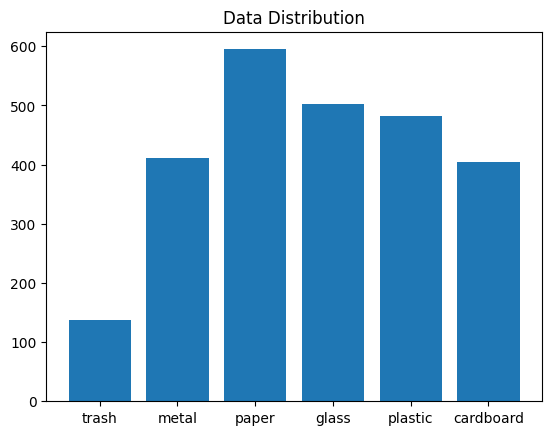

In [ ]:
total_data_class = []
for img_data in all_dir_class:
  total_data_class.append(len(os.listdir(os.path.join(base_path,img_data))))

plt.title("Data Distribution")
plt.bar(all_dir_class,total_data_class)
plt.show()


The data seem unbalanced especially in class of thrash. To solve this, using classweight may be an option

Showing 3 images on each classes

In [ ]:
plt.figure(figsize=(10,10))

for class_ind, class_name in enumerate(all_dir_class):
  images_path = os.path.join(base_path,class_name)
  images = os.listdir(images_path)
  for i in range(3):
    ax= plt.subplot(len(all_dir_class),3,class_ind*3+i+1)
    img = Image.open(os.path.join(images_path,images[i]))
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")  # Turn off axis

plt.tight_layout()
plt.show()

### b. Loading the dataset
The dataset loaded using tensorflow dataset. The dataset split to 80:20 for each training and validation. Dataset also performed with augmented to increase the number of the data. TF Autotune also perform to increase the performance during the training

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = ("/content/dataset-original")

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),

])

# Apply data augmentation to the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Configure the datasets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


The dataset is small for training full CNN from strach

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# 3. Building the model

The model using transfer learning on efficientNet. The output layer customized to perform classification on trash dataset. The model will train without and using class weight. The configuration declared for wandb monitoring


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="project1",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 512,
        "activation_1": "relu",
        "dropout_1": 0.2,
        "layer_2": 6,
        "activation_2": "softmax",
        "optimizer": "adam",
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 5,
        "batch_size": 64
    }
)
config = wandb.config
# Building Model

batch_size = 64
num_epochs = 10
image_height, image_width = 180, 180  # Adjust according to your image size


# Load EfficientNetB0 model pre-trained on ImageNet, excluding top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Freeze the base model
base_model.trainable = False


# Define the CNN model
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(config.layer_1,activation= config.activation_1),
    keras.layers.Dropout(config.dropout_1),
    keras.layers.Dense(config.layer_2, activation=config.activation_2)
])

model2 = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(config.layer_1,activation= config.activation_1),
    keras.layers.Dropout(config.dropout_1),
    keras.layers.Dense(config.layer_2, activation=config.activation_2)
])



In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric])



In [ ]:
    wandb_callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
    ]



Training model without class weight


In [ ]:
history = model.fit(augmented_train_ds,
                    epochs=config.epoch,validation_data = val_ds,
                    callbacks=wandb_callbacks,
                    batch_size=config.batch_size,
                    class_weight=class_weights)

Training model with class weight

In [ ]:
# Compile the model
model2.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric])



In [ ]:
# Step 1: Extract Class Distribution
class_names = train_ds.class_names
label_counts = {class_name: 0 for class_name in class_names}
for images, labels in train_ds.unbatch():
    label_counts[class_names[labels.numpy()]]+=1


# Step 2: Compute Class Weights
total_samples = sum(label_counts.values())
class_weights = {i: total_samples / (len(class_names) * count) for i, count in enumerate(label_counts.values())}


In [ ]:
history2 = model2.fit(augmented_train_ds,
                    epochs=config.epoch,validation_data = val_ds,
                    callbacks=wandb_callbacks,
                    batch_size=config.batch_size,
                    class_weight=class_weights)

In [ ]:
 wandb.finish()

# 4. Evaluation

Visualize the performance (model 1)

In [ ]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



Visualize performance (model 2)

In [ ]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [ ]:
def get_actual_predicted(model, dataset):
  actual = [labels for label, _ in dataset.unbatch()]
  predicted = model.predict(dataset)
  actual = tf.stack(actual, axis = 0)
  predicted = tf.concat(predicted, axis = 0)
  predicted = tf.argmax(predicted, axis = 1)
  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')